In [2]:
%matplotlib inline

In [2]:
import nengo
import numpy as np
from math import factorial

In [223]:
n_max = 140
c = 0.05
tau_star_min = -0.02
tau_stars = tau_star_min * (1 + c)**np.arange(n_max)

k = 8
#k = 10
ss = -k / tau_star_min / (1 + c)**(np.arange(n_max + 2 * k) - k)
ss_ = ss[k:-k]
ss_diff = np.diff(ss)
ss_diff2 = ss_diff[:-1] + ss_diff[1:]
f1 = ss_diff[:-1] / ss_diff[1:] / ss_diff2
f2 = ss_diff[1:] / ss_diff[:-1] / ss_diff2
a_ = np.diag(-np.concatenate((f2, (0,))), k=-1)
b_ = np.diag(np.concatenate(((0,), f2 - f1, (0,))))
c_ = np.diag(np.concatenate(((0,), f1)), k=1)
D1 = (a_ + b_ + c_)[1:-1]
Dk = np.eye(D1.shape[1])
for i in range(k):
    if i > 0:
        Dk = D1[i:-i, i:-i] @ Dk
    else:
        Dk = D1 @ Dk

Lk = (-1)**k / factorial(k) * (ss_[:, None])**(k+1) * Dk

In [224]:
tau_stars

array([ -0.02      ,  -0.021     ,  -0.02205   ,  -0.0231525 ,
        -0.02431013,  -0.02552563,  -0.02680191,  -0.02814201,
        -0.02954911,  -0.03102656,  -0.03257789,  -0.03420679,
        -0.03591713,  -0.03771298,  -0.03959863,  -0.04157856,
        -0.04365749,  -0.04584037,  -0.04813238,  -0.050539  ,
        -0.05306595,  -0.05571925,  -0.05850521,  -0.06143048,
        -0.064502  ,  -0.0677271 ,  -0.07111345,  -0.07466913,
        -0.07840258,  -0.08232271,  -0.08643885,  -0.09076079,
        -0.09529883,  -0.10006377,  -0.10506696,  -0.11032031,
        -0.11583632,  -0.12162814,  -0.12770955,  -0.13409502,
        -0.14079977,  -0.14783976,  -0.15523175,  -0.16299334,
        -0.17114301,  -0.17970016,  -0.18868516,  -0.19811942,
        -0.20802539,  -0.21842666,  -0.229348  ,  -0.2408154 ,
        -0.25285617,  -0.26549897,  -0.27877392,  -0.29271262,
        -0.30734825,  -0.32271566,  -0.33885144,  -0.35579402,
        -0.37358372,  -0.3922629 ,  -0.41187605,  -0.43

In [225]:
dt = 0.001

A = np.diag(-ss)
B = np.ones((len(ss), 1))
C = np.eye(len(ss))
D = np.zeros((len(ss), 1))

In [226]:
from nengolib.synapses import ss2sim

In [227]:
sys = ss2sim((A, B, C, D), nengo.Lowpass(0.1), dt)

In [228]:
#assert not np.any(A < -1.)

In [229]:
from scipy.signal import cont2discrete
A_, B_, C_, D_, dt = cont2discrete((A, B, C, D), dt=dt)

In [230]:
with nengo.Network() as model:
    inp = nengo.Node(lambda t: 1 < t <= 3 or 6 < t < 7)
    state = nengo.networks.EnsembleArray(
        3000, len(ss), neuron_type=nengo.LIFRate())
    for s, ens in zip(ss, state.ensembles):
        ens.radius = 1. / s
    nengo.Connection(inp, state.input, transform=sys.B, synapse=.1)
    nengo.Connection(state.output, state.input, transform=sys.A, synapse=0.1)#np.eye(len(ss)) + A, synapse=0.)
    output = nengo.Node(size_in=len(tau_stars))
    nengo.Connection(state.output, output, transform=Lk, solver=nengo.solvers.LstsqL2(reg=0.01))
    
    p_in = nengo.Probe(inp)
    p_state = nengo.Probe(state.output, synapse=0.01)
    p_out = nengo.Probe(output, synapse=0.01)

In [231]:
with nengo.Simulator(model) as sim:
    sim.run(10.)

Building finished in 0:03:02.                                                                                                                                                                                   
Simulating finished in 0:02:30.                                                                                                                                                                                 


In [232]:
with nengo.Network() as model_d:
    inp = nengo.Node(lambda t: 1 < t <= 3 or 6 < t < 7)
    state = nengo.networks.EnsembleArray(
        3000, len(ss), neuron_type=nengo.Direct())
    nengo.Connection(inp, state.input, transform=sys.B, synapse=.1)
    nengo.Connection(state.output, state.input, transform=sys.A, synapse=0.1)#np.eye(len(ss)) + A, synapse=0.)
    output = nengo.Node(size_in=len(tau_stars))
    nengo.Connection(state.output, output, transform=Lk)
    
    p_in_d = nengo.Probe(inp)
    p_state_d = nengo.Probe(state.output, synapse=0.01)
    p_out_d = nengo.Probe(output, synapse=0.01)

In [233]:
with nengo.Simulator(model_d) as sim_d:
    sim_d.run(10.)

Building finished in 0:00:01.                                                                                                                                                                                   
Simulating finished in 0:00:05.                                                                                                                                                                                 


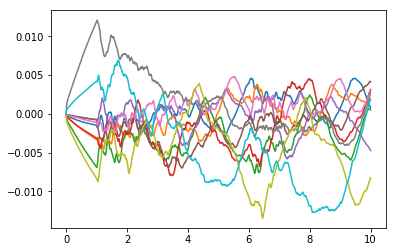

In [234]:
plt.plot(sim.trange(), (sim.data[p_state][:, :] - sim_d.data[p_state_d])[:, -10:]);

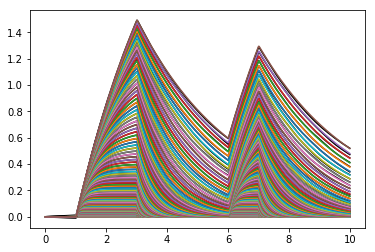

In [235]:
plt.plot(sim.trange(), sim.data[p_state][:, :], c='black');
plt.plot(sim_d.trange(), sim_d.data[p_state_d][:, :]);

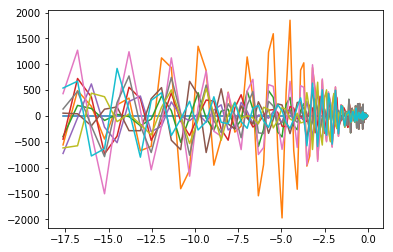

In [236]:
plt.plot(tau_stars, sim.data[p_out].T[:, ::1000]);

In [237]:
len(ss)

156

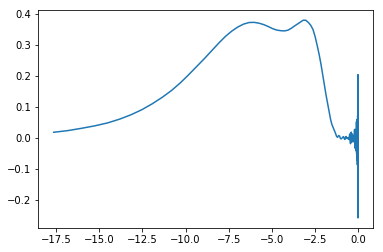

In [150]:
t = -1
plt.plot(tau_stars, Lk[:, ::] @ (sim.data[p_state][t] + 1e-9 * np.random.randn(sim.data[p_state].shape[1])))

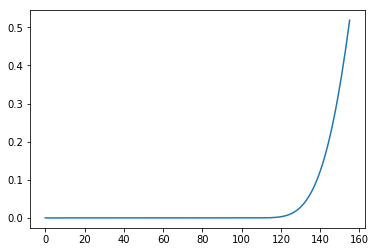

In [141]:
plt.plot(sim.data[p_state][t]);

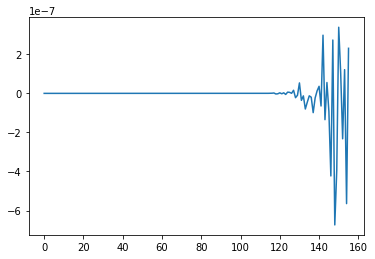

In [137]:
plt.plot(sim.data[p_state][t] - sim.data[p_state][t] * (1. + 1e-6 * np.random.randn(sim.data[p_state].shape[1])));

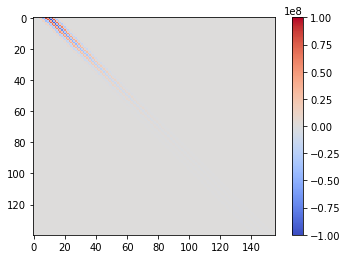

In [143]:
plt.imshow(Lk, cmap='coolwarm', vmin=-1e8, vmax=1e8);
plt.colorbar()

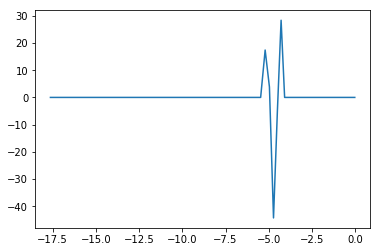

In [205]:
plt.plot(tau_stars, Lk[:, -30]);

In [144]:
Lk[-10:, -10:]

array([[  12259.38897107,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,       0.        ],
       [  -7366.52292074,   11675.60854388,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,       0.        ],
       [ -56853.19341204,   -7015.73611499,   11119.62718465,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,       0.        ],
       [  30509.66421847,  -54145.89848765,   -6681.65344285,
          10590.12112824,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,       0.        ],
       [ 115580.83121676,   29056.82306521,  -51567.52236919,
          -6363.47946938,   10085.82964594,       0.        ,
              0.        ,       0.        ,       0.    

In [9]:
from nengolib.networks import RollingWindow
from nengolib.synapses import PadeDelay
from nengolib.signal import cont2discrete
from nengolib.synapses import ss2sim

In [3]:
class RandomSPs(nengo.Process):
    def __init__(self, d, pointer_duration):
        super(RandomSPs, self).__init__()
        self.d = d
        self.pointer_duration = pointer_duration
        self.dist = nengo.dists.UniformHypersphere(surface=True)
        
    def make_step(self, shape_in, shape_out, dt, rng):
        steps_per_pointer = int(self.pointer_duration / dt)
        pointer = np.empty(self.d)
        def step(t):
            i = int(t / dt)
            if i % steps_per_pointer == 0:
                pointer[:] = self.dist.sample(1, self.d, rng=rng)
            return pointer[0]
        return step

In [278]:
with nengo.Network() as model:
    inp = nengo.Node(RandomSPs(256, 1.))
    state = RollingWindow(10, 22000, RandomSPs(256, 1.), dimensions=16, neuron_type=nengo.LIFRate())
    nengo.Connection(inp, state.input, synapse=None)
    output = state.add_output(np.linspace(0., 1., 250))
    #nengo.Connection(state.output, output)
    
    p_in = nengo.Probe(inp)
    p_state = nengo.Probe(state.output, synapse=0.01)
    p_out = nengo.Probe(output, synapse=0.01)

/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/scipy/signal/filter_design.py:1452: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


In [10]:
sys = ss2sim(PadeDelay(10., 16), nengo.Lowpass(0.1), dt=0.001)

In [71]:
with nengo.Network(seed=1) as model:
    inp = nengo.Node(RandomSPs(256, 1.))
    state = nengo.networks.EnsembleArray(2500, 16, neuron_type=nengo.LIFRate(), radius=25)
    nengo.Connection(state.output, state.input, transform=sys.A, synapse=0.1)
    nengo.Connection(inp, state.input, transform=sys.B, synapse=0.1)
    output = nengo.Node(size_in=1)
    nengo.Connection(state.output, output, transform=sys.C)
    
    p_in = nengo.Probe(inp)
    p_state = nengo.Probe(state.output, synapse=0.01)
    p_out = nengo.Probe(output, synapse=0.01)

In [72]:
with nengo.Simulator(model, seed=2) as sim:
    sim.run(30.)

Building finished in 0:00:03.                                                                                                                                                                                   
Simulating finished in 0:00:37.                                                                                                                                                                                 


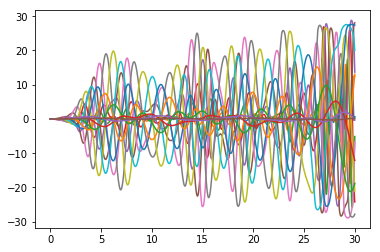

In [73]:
plt.plot(sim.trange(), sim.data[p_state]);

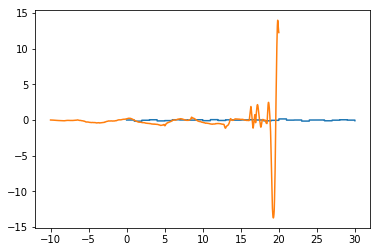

In [74]:
plt.plot(sim.trange(), sim.data[p_in])
plt.plot(sim.trange()-10., sim.data[p_out]);

/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/scipy/signal/filter_design.py:1452: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/nengolib/signal/system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


Building finished in 0:01:01.                                                                                                                                                                                   
Simulating finished in 0:00:01.                                                                                                                                                                                 


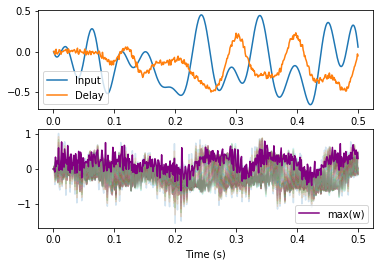

In [222]:
# See :doc:`notebooks.examples.rolling_window` for a notebook example.

from nengolib.networks import RollingWindow, t_default

# Approximate the maximum of a window of width 50 ms, as well as a sampling
# of the window itself. The :class:`.Hankel` realizer happens to be better
# than the default of :class:`.Balanced` for computing the ``max`` function.

import nengo
from nengolib import Network
from nengolib.signal import Hankel
with Network() as model:
    process = nengo.processes.WhiteSignal(100., high=25, y0=0)
    stim = nengo.Node(output=process)
    rw = RollingWindow(theta=.05, n_neurons=10000, process=process,
                       neuron_type=nengo.LIF(),
                       realizer=Hankel())
    nengo.Connection(stim, rw.input, synapse=None)
    p_stim = nengo.Probe(stim)
    p_delay = nengo.Probe(rw.output, synapse=0.01)
    p_max = nengo.Probe(rw.add_output(function=np.max))
    p_window = nengo.Probe(rw.add_output(function=lambda w: w[::20]))
with nengo.Simulator(model, seed=0) as sim:
    sim.run(.5)

import matplotlib.pyplot as plt
plt.subplot(211)
plt.plot(sim.trange(), sim.data[p_stim], label="Input")
plt.plot(sim.trange(), sim.data[p_delay], label="Delay")
plt.legend()
plt.subplot(212)
plt.plot(sim.trange(), sim.data[p_window], alpha=.2)
plt.plot(sim.trange(), sim.data[p_max], c='purple', label="max(w)")
plt.legend()
plt.xlabel("Time (s)")
plt.show()